In [1]:
from datamodules.ucg2cg import UCG2CGDataModule
from modules.diffusion_model import LitUCG2CGNoiseNet

In [2]:
datamodule = UCG2CGDataModule(
        cg_files       = ["sample-data/cg/pfpatch_000000000138.npz", "sample-data/cg/pfpatch_000000000214.npz", "sample-data/cg/pfpatch_000000000272.npz"],
        ucg_files      = ["sample-data/ucg/pfpatch_000000000138_ucg.npz", "sample-data/ucg/pfpatch_000000000214_ucg.npz", "sample-data/ucg/pfpatch_000000000272_ucg.npz"],
        ucg_index_file = "sample-data/cg/all_indices_per_cluster.npz",
        batch_size     = 3,
        num_workers    = 1,
        train_size     = 0.5,
    )

In [5]:
datamodule.setup()
loader = datamodule.val_dataloader()
batch = next(iter(loader))
ucg_pos = batch['ucg_pos']
cg_pos = batch["cg_pos"]

In [3]:
ckpt_path = 'lightning_logs/version_8/checkpoints/epoch=1800-step=585325.ckpt'
# ckpt_path = "lit_logs/dimers-C/version_0/checkpoints/epoch=16-step=100.ckpt"
noise_net = LitUCG2CGNoiseNet.load_from_checkpoint(ckpt_path, ucg_index_file="sample-data/cg/all_indices_per_cluster.npz")



In [6]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

noise_net = noise_net.to(device)
ucg_pos = ucg_pos.to(device)

pred_cg_pos = noise_net.generate(ucg_pos, num_steps=10)

In [7]:
import numpy as np
import torch
from utils.datautils import DataUtils
from utils.viz import plot_rmsds

def generate_rmsd_plot(num_steps):
    # Collect RMSDs
    all_rmsds = []

    datamodule.setup()
    val_loader = datamodule.val_dataloader()

    noise_net.eval()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for batch in val_loader:
        ucg_pos = batch["ucg_pos"].to(device)  # shape: (B, N, 3)
        cg_pos = batch["cg_disp"].numpy()    # shape: (B, N, 3)

        with torch.no_grad():
            pred_cg_pos = noise_net.generate(ucg_pos, num_steps)
            
        pred_cg_pos = pred_cg_pos[:,-1,:,:]
        pred_cg_pos = pred_cg_pos.cpu().numpy()

        batch_rmsds = DataUtils.rmsd(pred_cg_pos, cg_pos)  # shape: (B,)
        all_rmsds.extend(batch_rmsds.tolist())

    all_rmsds = np.array(all_rmsds)

    # Plotting
    plot_rmsds(all_rmsds, title="Validation RMSD Distribution", filename="val_rmsd.png")

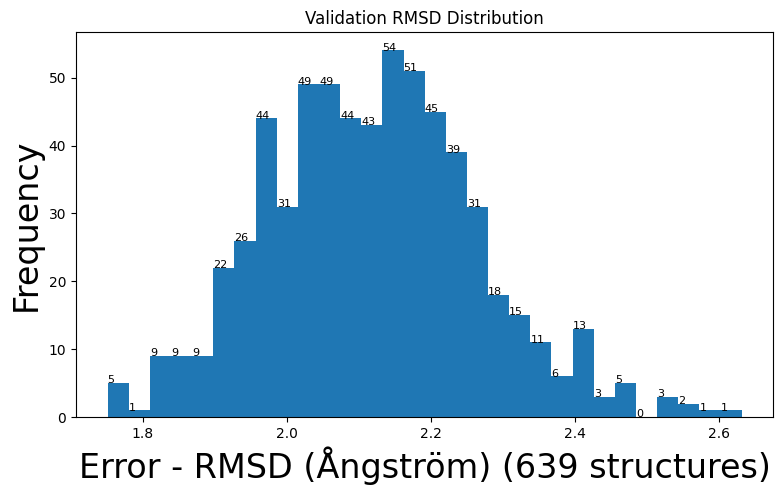

In [12]:
generate_rmsd_plot(num_steps=10)

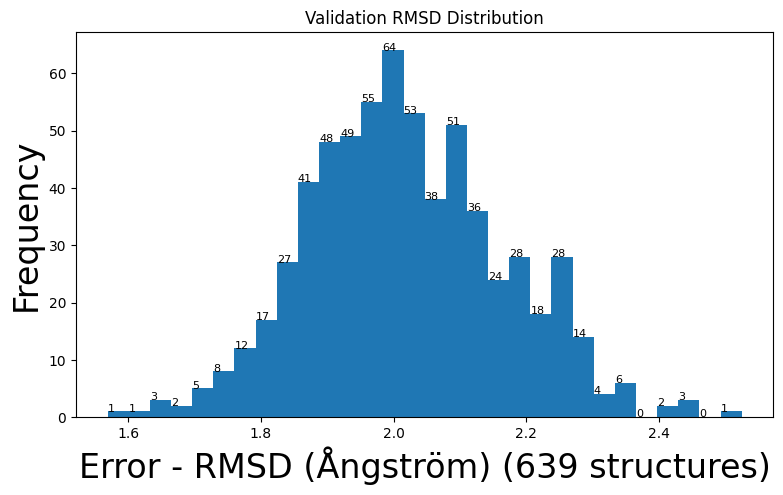

In [9]:
generate_rmsd_plot(num_steps=50)

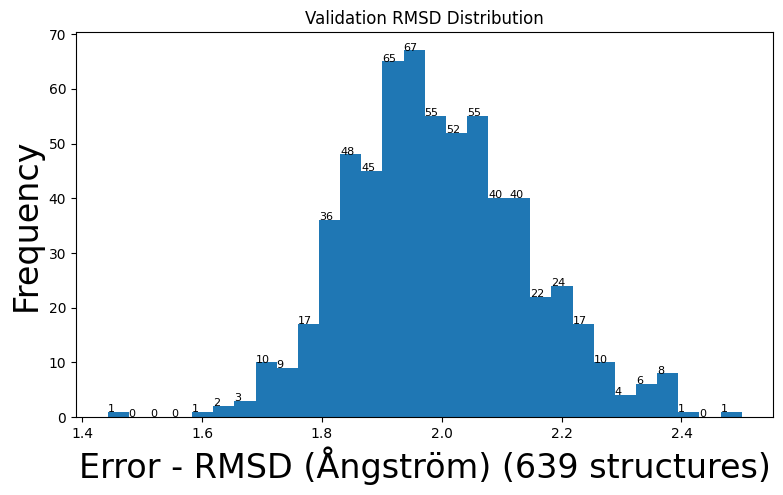

In [10]:
generate_rmsd_plot(num_steps=500)

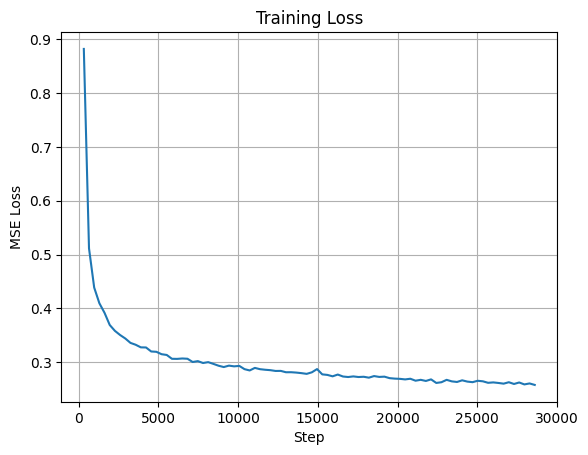

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/jonathan/Downloads/version_7_train.csv")
plt.plot(df['Step'], df['Value'])
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.grid(True)
# plt.savefig("loss_plot.png", dpi=300)  # Saves a high-quality image
plt.show()

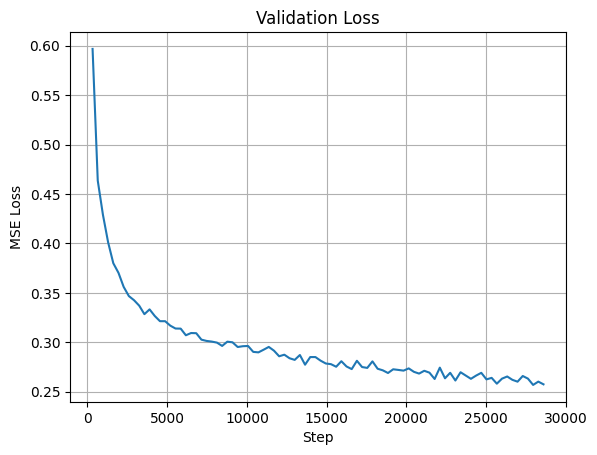

In [16]:
df = pd.read_csv("/Users/jonathan/Downloads/version_7_validation.csv")
plt.plot(df['Step'], df['Value'])
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.title("Validation Loss")
plt.grid(True)
# plt.savefig("loss_plot.png", dpi=300)  # Saves a high-quality image
plt.show()

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_diffusion_samples(samples, titles=None):
    """
    Visualize 3 CG protein samples at different diffusion timesteps.

    Args:
        samples (list of np.ndarray): List of 3 arrays of shape (N, 3)
        titles (list of str): Optional titles for each subplot
    """
    assert len(samples) == 3, "Expected 3 samples"
    fig = plt.figure(figsize=(15, 5))
    
    for i, coords in enumerate(samples):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')
        ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='b', s=40)
        ax.set_title(titles[i] if titles else f"Timestep {i * 250}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_box_aspect([1,1,1])  # Equal aspect ratio

    plt.tight_layout()
    plt.show()

In [7]:
datamodule = UCG2CGDataModule(
        cg_files       = ["sample-data/cg/pfpatch_000000000138.npz", "sample-data/cg/pfpatch_000000000214.npz", "sample-data/cg/pfpatch_000000000272.npz"],
        ucg_files      = ["sample-data/ucg/pfpatch_000000000138_ucg.npz", "sample-data/ucg/pfpatch_000000000214_ucg.npz", "sample-data/ucg/pfpatch_000000000272_ucg.npz"],
        ucg_index_file = "sample-data/cg/all_indices_per_cluster.npz",
        batch_size     = 3,
        num_workers    = 1,
        train_size     = 0.5,
    )

In [40]:
datamodule.setup()
val_loader = datamodule.val_dataloader()
batch = next(iter(loader))

noise_net.eval()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


ucg_pos = batch["ucg_pos"].to(device)  # shape: (B, N, 3)
# cg_disp = batch["cg_disp"].numpy()    # shape: (B, N, 3)

with torch.no_grad():
    pred_cg_disp = noise_net.generate(ucg_pos, 100)
    
pred_cg_disp = pred_cg_disp[:,-1,:,:]


In [46]:
pred_cg_disp.shape

torch.Size([3, 751, 3])

In [51]:
# print(pred_cg_disp.shape)
pred_cg_pos = ucg_pos[:, batch['scatter_idx'][0,:], :] + pred_cg_disp
# pred_cg_disp = pred_cg_disp.cpu().numpy()

In [52]:
ucg_pos.shape

torch.Size([3, 40, 3])

In [53]:
batch['scatter_idx'].shape

torch.Size([3, 751])

In [54]:
pred_cg_pos.shape

torch.Size([3, 751, 3])

In [55]:
pred_cg_disp.shape

torch.Size([3, 751, 3])

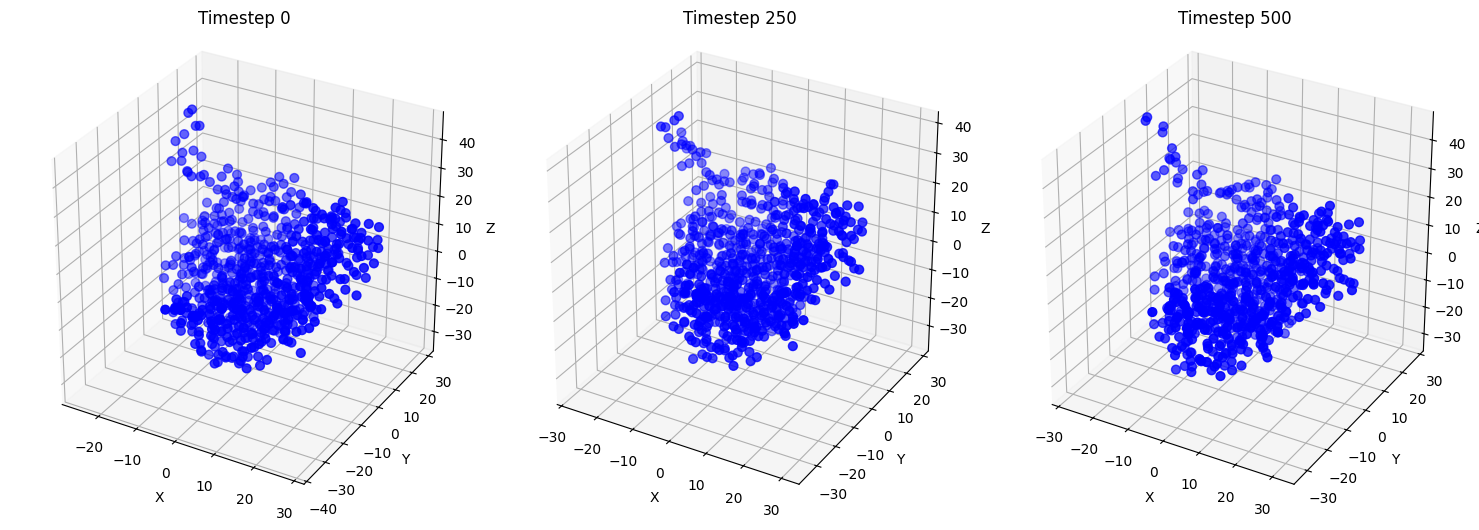

In [58]:
# data = np.load("pred-cg-500.npy")
# print(data.shape)
samples = [pred_cg_pos[0,:,:].cpu(), pred_cg_pos[1,:,:].cpu(), pred_cg_pos[2,:,:].cpu()]
plot_diffusion_samples(samples)